<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE30338](https://jckantor.github.io/CBE30338);
content is available [on Github](https://github.com/jckantor/CBE30338.git).*

<!--NAVIGATION-->
< [7.7 Transient Heat Transfer in Various Geometries](https://jckantor.github.io/CBE30338/07.07-Transient-Heat-Transfer-in-Various-Geometries.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [8.0 Predictive Control](https://jckantor.github.io/CBE30338/08.00-Predictive-Control.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/07.08-Path-Constraints.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>

# 7.8 Path Constraints

https://github.com/Pyomo/pyomo/blob/master/examples/dae/Path_Constraint.py

In [1]:
#
#  Pyomo: Python Optimization Modeling Objects
#  Copyright 2017 National Technology and Engineering Solutions of Sandia, LLC
#  Under the terms of Contract DE-NA0003525 with National Technology and 
#  Engineering Solutions of Sandia, LLC, the U.S. Government retains certain 
#  rights in this software.
#  This software is distributed under the 3-clause BSD License.

# Sample Problem 3: Inequality State Path Constraint
# (Ex 4 from Dynopt Guide)
#
#   min x3(tf)
#   s.t.    X1_dot = X2                     X1(0) =  0
#           X2_dot = -X2+u                  X2(0) = -1
#           X3_dot = X1^2+x2^2+0.005*u^2    X3(0) =  0
#           X2-8*(t-0.5)^2+0.5 <= 0
#           tf = 1
#

In [30]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()
m.tf = Param(initialize=1)
m.t = ContinuousSet(bounds=(0,m.tf))

m.u = Var(m.t, initialize=0)
m.x1 = Var(m.t)
m.x2 = Var(m.t)
m.x3 = Var(m.t)

m.dx1 = DerivativeVar(m.x1, wrt=m.t)
m.dx2 = DerivativeVar(m.x2, wrt=m.t)
m.dx3 = DerivativeVar(m.x3, wrt=m.t)

m.obj = Objective(expr=m.x3[m.tf])

def _x1dot(m, t):
    if t == 0:
        return Constraint.Skip
    return m.dx1[t] == m.x2[t]
m.x1dotcon = Constraint(m.t, rule=_x1dot)

def _x2dot(m, t):
    if t == 0:
        return Constraint.Skip

    return m.dx2[t] ==  -m.x2[t]+m.u[t]
m.x2dotcon = Constraint(m.t, rule=_x2dot)

def _x3dot(m, t):
    if t == 0:
        return Constraint.Skip

    return m.dx3[t] == m.x1[t]**2+m.x2[t]**2+0.005*m.u[t]**2
m.x3dotcon = Constraint(m.t, rule=_x3dot)

def _con(m, t):
    return m.x2[t]-8*(t-0.5)**2+0.5 <= 0
m.con = Constraint(m.t, rule=_con)

def _init(m):
    yield m.x1[0] == 0
    yield m.x2[0] == -1
    yield m.x3[0] == 0
m.init_conditions = ConstraintList(rule=_init)

In [31]:
# transform and solve
TransformationFactory('dae.collocation').apply_to(m, wrt=m.t, nfe=3, ncp=12, method='BACKWARD')
SolverFactory('ipopt').solve(m).write()

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 256
  Number of variables: 255
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.08427214622497559
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


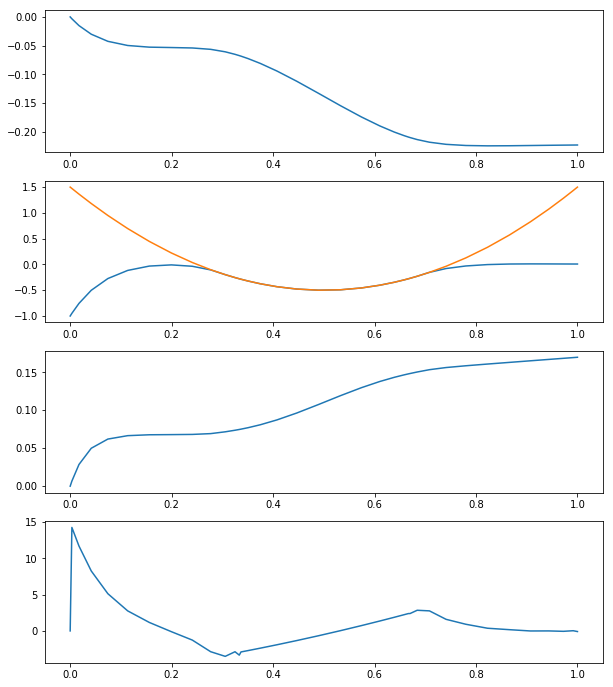

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = [t for t in m.t]

u = [m.u[t]() for t in t]
x1 = [m.x1[t]() for t in m.x1]
x2 = [m.x2[t]() for t in m.x2]
x3 = [m.x3[t]() for t in m.x3]

plt.figure(figsize=(10,12))
plt.subplot(4,1,1)
plt.plot(t, x1)

#X2-8*(t-0.5)^2+0.5 <= 0

plt.subplot(4,1,2)
plt.plot(t, x2)
plt.plot(t, 8*(np.array(t)-0.5)**2 - 0.5)

plt.subplot(4,1,3)
plt.plot(t, x3)

plt.subplot(4,1,4)
plt.plot(t, u)

## 7.8.1 Recoding for Compact Style

In [9]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()
m.tf = Param(initialize=1)
m.t = ContinuousSet(bounds=(0, m.tf))

m.u = Var(m.t, initialize=0)
m.x1 = Var(m.t)
m.x2 = Var(m.t)
m.x3 = Var(m.t)

m.dx1 = DerivativeVar(m.x1)
m.dx2 = DerivativeVar(m.x2)
m.dx3 = DerivativeVar(m.x3)

m.obj = Objective(expr=m.x3[m.tf])

m.x1dotcon = Constraint(m.t, rule=lambda m, t: m.dx1[t] == m.x2[t])
m.x2dotcon = Constraint(m.t, rule=lambda m, t: m.dx2[t] == -m.x2[t] + m.u[t])
m.x3dotcon = Constraint(m.t, rule=lambda m, t: m.dx3[t] == m.x1[t]**2+m.x2[t]**2+0.005*m.u[t]**2)
m.con = Constraint(m.t, rule=lambda m, t: m.x2[t]-8*(t-0.5)**2+0.5 <= 0)

m.x1dotcon[0].deactivate()
m.x2dotcon[0].deactivate()
m.x3dotcon[0].deactivate()

m.ic = ConstraintList()
m.ic.add(m.x1[0] == 0)
m.ic.add(m.x2[0] == -1)
m.ic.add(m.x3[0] == 0)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 256
  Number of variables: 255
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.1155850887298584
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


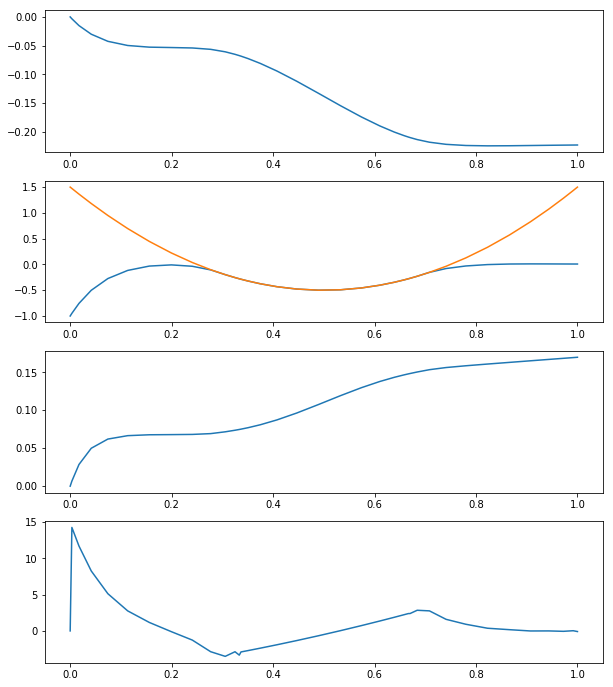

In [10]:
# transform and solve
TransformationFactory('dae.collocation').apply_to(m, wrt=m.t, nfe=3, ncp=12, method='BACKWARD')
SolverFactory('ipopt').solve(m).write()

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = [t for t in m.t]

u = [m.u[t]() for t in t]
x1 = [m.x1[t]() for t in m.x1]
x2 = [m.x2[t]() for t in m.x2]
x3 = [m.x3[t]() for t in m.x3]

plt.figure(figsize=(10,12))
plt.subplot(4,1,1)
plt.plot(t, x1)

#X2-8*(t-0.5)^2+0.5 <= 0

plt.subplot(4,1,2)
plt.plot(t, x2)
plt.plot(t, 8*(np.array(t)-0.5)**2 - 0.5)

plt.subplot(4,1,3)
plt.plot(t, x3)

plt.subplot(4,1,4)
plt.plot(t, u)

## 7.8.2 Subscripting Equations

In [46]:
from pyomo.environ import *
from pyomo.dae import *

m = ConcreteModel()
m.tf = Param(initialize=1)
m.t = ContinuousSet(bounds=(0, m.tf))

m.u = Var(m.t, initialize=0)
m.N = [1, 2, 3]

m.x = Var(m.N, m.t)
m.dx = DerivativeVar(m.x)

m.obj = Objective(expr=m.x[3,m.tf])

def ode(m, n, t):
    if t==0: 
        return Constraint.Skip
    odes = {
        1: m.dx[1,t] == m.x[2,t],
        2: m.dx[2,t] == -m.x[2,t] + m.u[t],
        3: m.dx[3,t] == m.x[1,t]**2 + m.x[2,t]**2 + 0.005*m.u[t]**2
    }
    return odes[n]
m.ode = Constraint(m.N, m.t, rule=ode)
m.con = Constraint(m.t, rule=lambda m, t: m.x[2,t]-8*(t-0.5)**2+0.5 <= 0)

m.ic = ConstraintList()
m.ic.add(m.x[1,0] == 0)
m.ic.add(m.x[2,0] == -1)
m.ic.add(m.x[3,0] == 0)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 256
  Number of variables: 255
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.8\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.09073829650878906
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


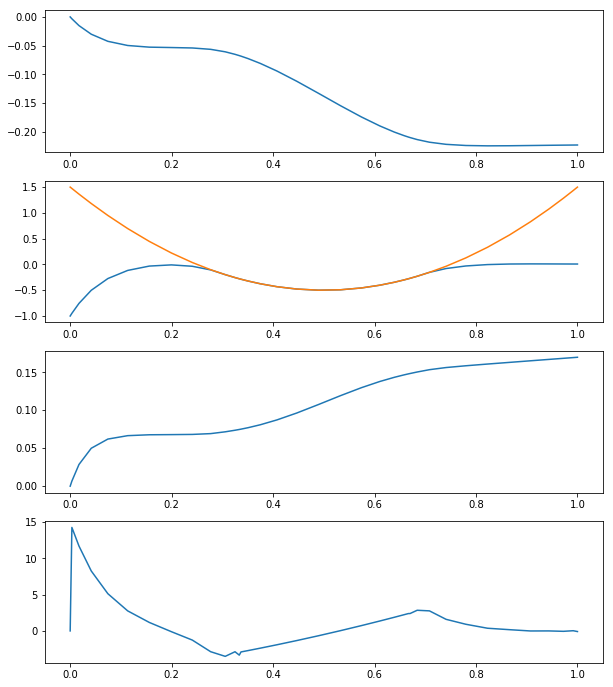

In [47]:
# transform and solve
TransformationFactory('dae.collocation').apply_to(m, wrt=m.t, nfe=3, ncp=12, method='BACKWARD')
SolverFactory('ipopt').solve(m).write()

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

t = [t for t in m.t]

u = [m.u[t]() for t in t]
x1 = [m.x[1,t]() for t in t]
x2 = [m.x[2,t]() for t in t]
x3 = [m.x[3,t]() for t in t]

plt.figure(figsize=(10,12))
plt.subplot(4,1,1)
plt.plot(t, x1)

plt.subplot(4,1,2)
plt.plot(t, x2)
plt.plot(t, 8*(np.array(t)-0.5)**2 - 0.5)

plt.subplot(4,1,3)
plt.plot(t, x3)

plt.subplot(4,1,4)
plt.plot(t, u)

<!--NAVIGATION-->
< [7.7 Transient Heat Transfer in Various Geometries](https://jckantor.github.io/CBE30338/07.07-Transient-Heat-Transfer-in-Various-Geometries.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [8.0 Predictive Control](https://jckantor.github.io/CBE30338/08.00-Predictive-Control.html)<p><a href="https://colab.research.google.com/github/jckantor/CBE30338/blob/master/docs/07.08-Path-Constraints.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>